# Causal Machine Learning Tutorial

This is a tutorial in using two different causal machine learning approaches: targeted maximum likelihood estimation (TMLE) and double/debiased machine learning (DML). These methods are both going to be used to estimate the treatment effect for a binary treatment.  
  
See the paper here: *Luque-Fernandez MA, Schomaker M, Rachet B, Schnitzer ME. Targeted maximum likelihood estimation for a binary treatment: A tutorial. Statistics in Medicine. 2018; 37: 2530–2546. https://doi.org/10.1002/sim.7628*

In [47]:
import sys
import os

# Add src to the Python path
sys.path.append(os.path.abspath('../src'))

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit 

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC

from tutorial import generate_data, produce_dag, generate_data_nonlinearity

In [49]:
from doubleml import DoubleMLData
from doubleml import DoubleMLIRM

from tmle import targeting_step

import statsmodels.api as sm
import statsmodels.formula.api as smf # allows R-like syntax 

### Data Generating Function
  
Causal ML is about inferring parameters of some data generating function.
  
A key element is the DAG, we work off the following DAG (taken directly from the paper). This DAG is intended to simulate the causal pathway for mortality from cancer treatment 
  
We then generate date based on that DAG:
- `W1` ('sex') and `W2` ('age category') are generated as Bernoulli variables with probabibility 0.5 and 0.65 respectively 
- `W3` ('cancer stage') and `W4` ('comorbidities') are generated as ordinal variables with 4 and 5 levels respectively. The value for each is generated as a random uniform distribution and the values are rounded off to the closest integer
- `A` ('treatment variable') and `Y` ('outcome variable') are generated as binary indicators using a log-linear model. In the treatment and outcome models, there is an interaction term between `W2` and `W4` based on e.g. 'increased risk of comorbidities among older adults' 

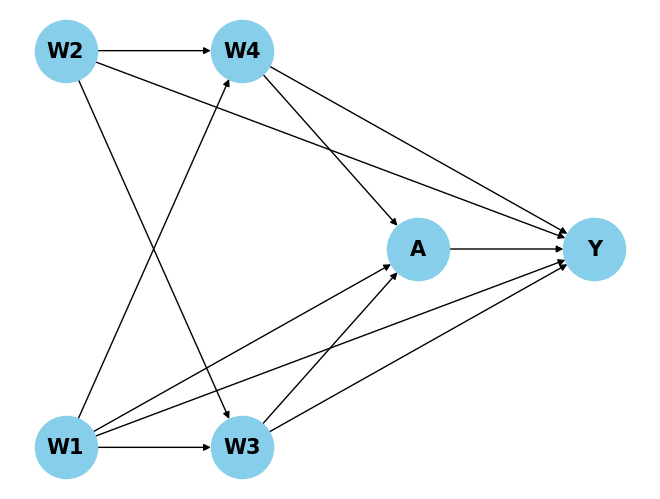

In [50]:
fig = produce_dag()
plt.show()

In [51]:
df = generate_data_nonlinearity(2000000, 555) # generate a huge dataset from which we can calculate the 'true' ATE

true_EY1 = df['Y1'].mean()
true_EY0 = df['Y0'].mean()
true_ATE = true_EY1-true_EY0
print(f'True ATE = {true_ATE}')

True ATE = 0.17865750000000002


In [52]:
# now generate a much smaller dataset that we will actually use for our methods
df = generate_data_nonlinearity(20000, 556)
df

,w1,w2,w3,w4,A,Y,Y1,Y0
0,1.0,0.0,0.440,0.067,0.0,0.0,0.0,0.0
1,0.0,0.0,1.719,0.747,0.0,0.0,1.0,0.0
2,1.0,1.0,3.917,3.499,1.0,1.0,1.0,1.0
3,1.0,1.0,2.529,2.511,1.0,1.0,1.0,0.0
4,0.0,1.0,1.705,3.281,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...
19995,1.0,1.0,1.606,2.641,0.0,0.0,1.0,0.0
19996,1.0,0.0,0.970,3.487,1.0,1.0,1.0,1.0
19997,0.0,1.0,2.558,1.840,0.0,1.0,1.0,1.0
19998,0.0,1.0,3.914,0.773,0.0,1.0,1.0,1.0


In [53]:
newdata_A1 = df.copy()
newdata_A1['A'] = 1

newdata_A0 = df.copy()
newdata_A0['A'] = 0


# TMLE  

### Using a superlearner model  
  
Trying out TMLE, using a superlearner model for the Outcome and Propensity Score models

In [54]:
# Define predictors and outcome
X = df[['A', 'w1', 'w2', 'w3', 'w4']]  # Covariates and treatment
y = df['Y']  # Outcome

# Define base models
base_models = [
    ('gradient_boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
    ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(probability=True, kernel='linear', random_state=42))
]

# Define meta-model
meta_model = LogisticRegression()

# Create the stacking classifier
outcome_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Fit the stacking model
outcome_model.fit(X, y)

# Predict probabilities
QA = outcome_model.predict_proba(X)[:,1]
Q1 = outcome_model.predict_proba(newdata_A1[['A', 'w1', 'w2', 'w3', 'w4']])[:,1]
Q0 = outcome_model.predict_proba(newdata_A0[['A', 'w1', 'w2', 'w3', 'w4']])[:,1]

In [55]:

# Define predictors and outcome
X = df[['w1', 'w2', 'w3', 'w4']]  # Covariates and treatment
y = df['A']  # Outcome

# Define base models
base_models = [
    ('gradient_boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
    ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(probability=True, kernel='linear', random_state=42))
]

# Define meta-model
meta_model = LogisticRegression()

# Create the stacking classifier
ps_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Fit the stacking model
ps_model.fit(X, y)

propensity_estimates_sl = ps_model.predict_proba(X)[:,1]

In [56]:
target_model = targeting_step(df, propensity_estimates_sl, QA) # carries out the targeting step to optimise the b-v tradeoff for the ATE
epsilon = target_model.params # coefficients in this targeting step

# use the epsilon values to improve the treatment model

# Convert Q0W and Q1W to logit scale and update them
logit_Q0 = np.log(Q0 / (1 - Q0))
logit_Q1 = np.log(Q1 / (1 - Q1))

# Update logit values with epsilon adjustments
logit_Q0_1 = logit_Q0 + epsilon['H0W'] / (1 - propensity_estimates_sl)
logit_Q1_1 = logit_Q1 + epsilon['H1W'] / propensity_estimates_sl

# Convert back to probabilities using inverse-logit
Q0_1 = expit(logit_Q0_1)
Q1_1 = expit(logit_Q1_1)

# Now we can calculate an improved ATE
EY1_tmle = Q1_1.mean()
EY0_tmle = Q0_1.mean()
ATE_tmle = EY1_tmle - EY0_tmle

## Double Machine Learning

In [57]:
# convert dataset to double ML data variable
dml_data_obj = DoubleMLData(df, 'Y', 'A', ['w1', 'w2', 'w3', 'w4'])

In [58]:
# Use stacking classifiers for the models in double ML as well

# Define base models
base_models = [
    ('gradient_boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
    ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(probability=True, kernel='linear', random_state=42))
]

# Define meta-model
meta_model = LogisticRegression()

# Create the stacking classifier
ml_l_g = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

In [59]:
# Use stacking classifiers for the models in double ML as well

# Define base models
base_models2 = [
    ('gradient_boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
    ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(probability=True, kernel='linear', random_state=42))
]

# Define meta-model
meta_model2 = LogisticRegression()

# Create the stacking classifier
ml_l_m = StackingClassifier(estimators=base_models2, final_estimator=meta_model2, cv=5)

In [60]:
dml_model = DoubleMLIRM(dml_data_obj, 
                        ml_g = ml_l_g, 
                        ml_m = ml_l_m,
                        n_folds = 5, 
                        score = 'ATE')

In [ ]:
# fit the model 
dml_model = dml_model.fit()

In [ ]:
print(dml_model.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
A  0.210997  0.009524  22.154871  9.362747e-109  0.192331  0.229663


## Comparison of the two values 

In [ ]:
results_df = pd.DataFrame(
    {
        'True ATE' : [true_ATE, 100*abs(true_ATE-true_ATE)/true_ATE], 
        'ATE (TMLE)' : [ATE_tmle, 100*abs(ATE_tmle-true_ATE)/true_ATE], 
        'ATE (DML)' : [dml_model.coef[0], 100*abs(dml_model.coef[0]-true_ATE)/true_ATE]
    },
    index=['Value', 'Difference from true ATE']
)

In [ ]:
print(results_df)

                          True ATE  ATE (TMLE)  ATE (DML)
Value                     0.178658    0.207942   0.210997
Difference from true ATE  0.000000   16.391369  18.101390
